# Necessary Packages

In [47]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.probability import FreqDist
from wordcloud import WordCloud
import spacy


In [ ]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm") # python3 -m spacy download en_core_web_sm

# Preprocessing

In [33]:
df = pd.read_csv('Food Ingredients and Recipe Dataset with Image Name Mapping.csv', index_col=0)
df.head()

,Title,Ingredients,Instructions,Image_Name,Cleaned_Ingredients
0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...","Pat chicken dry with paper towels, season all ...",miso-butter-roast-chicken-acorn-squash-panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher..."
1,Crispy Salt and Pepper Potatoes,"['2 large egg whites', '1 pound new potatoes (...",Preheat oven to 400°F and line a rimmed baking...,crispy-salt-and-pepper-potatoes-dan-kluger,"['2 large egg whites', '1 pound new potatoes (..."
2,Thanksgiving Mac and Cheese,"['1 cup evaporated milk', '1 cup whole milk', ...",Place a rack in middle of oven; preheat to 400...,thanksgiving-mac-and-cheese-erick-williams,"['1 cup evaporated milk', '1 cup whole milk', ..."
3,Italian Sausage and Bread Stuffing,"['1 (¾- to 1-pound) round Italian loaf, cut in...",Preheat oven to 350°F with rack in middle. Gen...,italian-sausage-and-bread-stuffing-240559,"['1 (¾- to 1-pound) round Italian loaf, cut in..."
4,Newton's Law,"['1 teaspoon dark brown sugar', '1 teaspoon ho...",Stir together brown sugar and hot water in a c...,newtons-law-apple-bourbon-cocktail,"['1 teaspoon dark brown sugar', '1 teaspoon ho..."


In [34]:
df = df.drop('Image_Name', axis = 1)
df.head()

,Title,Ingredients,Instructions,Cleaned_Ingredients
0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...","Pat chicken dry with paper towels, season all ...","['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher..."
1,Crispy Salt and Pepper Potatoes,"['2 large egg whites', '1 pound new potatoes (...",Preheat oven to 400°F and line a rimmed baking...,"['2 large egg whites', '1 pound new potatoes (..."
2,Thanksgiving Mac and Cheese,"['1 cup evaporated milk', '1 cup whole milk', ...",Place a rack in middle of oven; preheat to 400...,"['1 cup evaporated milk', '1 cup whole milk', ..."
3,Italian Sausage and Bread Stuffing,"['1 (¾- to 1-pound) round Italian loaf, cut in...",Preheat oven to 350°F with rack in middle. Gen...,"['1 (¾- to 1-pound) round Italian loaf, cut in..."
4,Newton's Law,"['1 teaspoon dark brown sugar', '1 teaspoon ho...",Stir together brown sugar and hot water in a c...,"['1 teaspoon dark brown sugar', '1 teaspoon ho..."


In [46]:
df.count()

Title                  13493
Ingredients            13493
Instructions           13493
Cleaned_Ingredients    13493
dtype: int64

In [36]:
df.isna().sum()

Title                  5
Ingredients            0
Instructions           8
Cleaned_Ingredients    0
dtype: int64

In [38]:
df = df.dropna()

In [39]:
df.isna().sum()

Title                  0
Ingredients            0
Instructions           0
Cleaned_Ingredients    0
dtype: int64

In [44]:
# Basic statistics
word_count = df['Cleaned_Ingredients'].apply(lambda x: len(nltk.word_tokenize(x)))
sentence_count = df['Cleaned_Ingredients'].apply(lambda x: len(nltk.sent_tokenize(x)))
char_count = df['Cleaned_Ingredients'].apply(len)

# Display basic statistics
print(word_count, sentence_count, char_count)

0        229
1         62
2         88
3        140
4         57
        ... 
13496    103
13497    102
13498     65
13499     58
13500    202
Name: Cleaned_Ingredients, Length: 13493, dtype: int64 0        15
1         1
2         9
3         1
4         3
         ..
13496     1
13497     1
13498     1
13499     1
13500     1
Name: Cleaned_Ingredients, Length: 13493, dtype: int64 0        830
1        251
2        289
3        558
4        218
        ... 
13496    413
13497    405
13498    271
13499    211
13500    762
Name: Cleaned_Ingredients, Length: 13493, dtype: int64


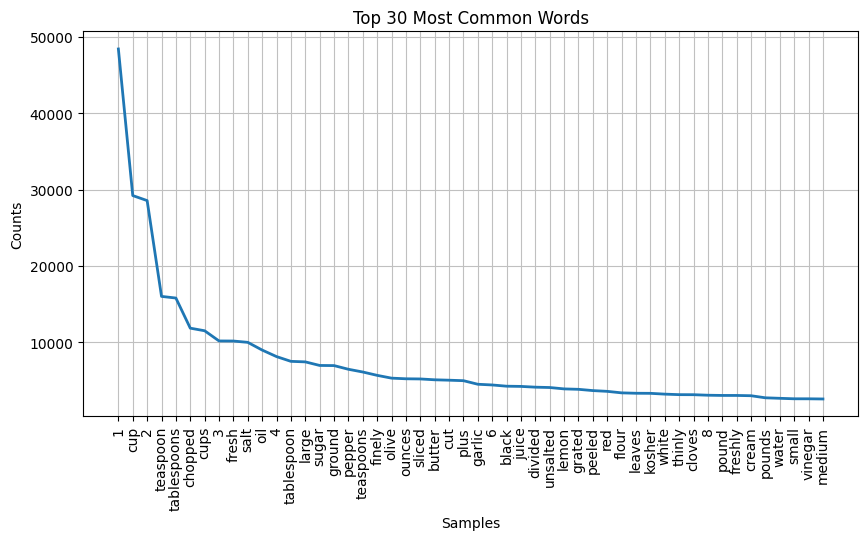

<Axes: title={'center': 'Top 30 Most Common Words'}, xlabel='Samples', ylabel='Counts'>

In [50]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# Tokenize and remove stop words
df['tokens'] = df['Cleaned_Ingredients'].apply(lambda x: [word for word in nltk.word_tokenize(x.lower()) if word.isalnum() and word not in stop_words])

# Frequency distribution of words
all_words = [word for tokens_list in df['tokens'] for word in tokens_list]
freq_dist = FreqDist(all_words)

# Plot the most common words
plt.figure(figsize=(10, 5))
freq_dist.plot(50, title='Top 30 Most Common Words')


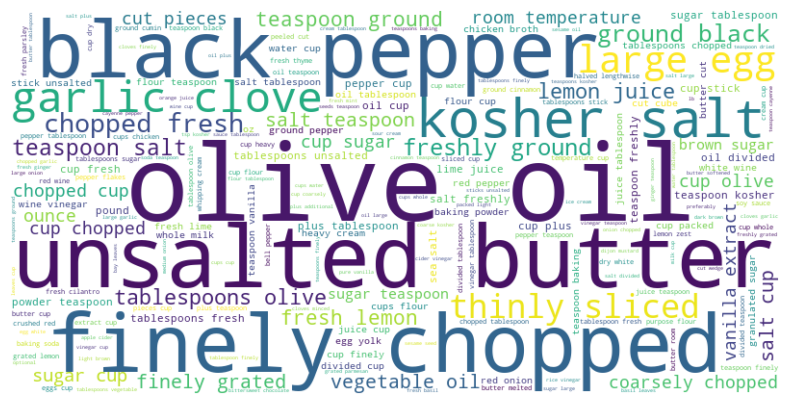

In [51]:
# Generate and display a word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


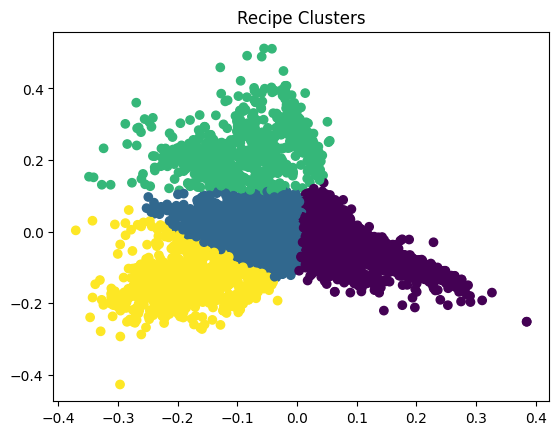

In [20]:
# Vectorization
vectorizer = TfidfVectorizer()
titles = vectorizer.fit_transform(df['Title'])

# Dimensionality Reduction
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(titles.toarray())

# Clustering
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(X_reduced)
df['Cluster'] = clusters    
# Visualization
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters)
plt.title('Recipe Clusters')
plt.show()


# Model

In [21]:
# we are prediciting based on ingredients so we will use ingredients column
vectorizer = TfidfVectorizer()
ingredients_matrix = vectorizer.fit_transform(df['Cleaned_Ingredients'])
kmeans = KMeans(n_clusters=4, random_state=0)
df['Ingredients_Cluster'] = kmeans.fit_predict(ingredients_matrix)

In [27]:
def recommend_dishes(data, user_input, n_recommendations):
    user_input = user_input.lower()
    user_vector = vectorizer.transform([user_input])

    user_cluster = kmeans.predict(user_vector)[0]
    cluster_data = data[data['Cluster'] == user_cluster]
    cluster_matrix = vectorizer.transform(cluster_data['Cleaned_Ingredients'])
    
    similarities = cosine_similarity(user_vector, cluster_matrix)
    top_indices = similarities[0].argsort()[-n_recommendations:][::-1]
    recommended_dishes = cluster_data.iloc[top_indices]
    
    return recommended_dishes[['Title', 'Cleaned_Ingredients', 'Instructions']]


In [28]:
data = df
user_input = 'chicken, rice'
n_recommendations = 5
recommend_dishes(data, user_input, n_recommendations)

,Title,Cleaned_Ingredients,Instructions
12336,Yellow Rice,"['2 teaspoons vegetable oil', '2 tablespoons c...",Heat oil in heavy medium saucepan over medium-...
6401,Parboiled Rice,"['""2 cups Indian parboiled rice', 'Uncle Bens ...",Bring 3 to 4 quarts water to a boil in a pasta...
9551,Chinese Black Rice,"['2 cups Chinese black rice', '3 1/2 cups water']",Rinse rice in a sieve under cold running water...
2855,Simple Ponzu Sauce,"['1 teaspoon sugar', '1 tablespoon fresh lime ...",Stir sugar and 1 Tbsp. warm water in a small b...
7743,Ginger-Cilantro Rice,"['1 cup long-grain white rice', '2 1-inch-long...",Combine rice and ginger rounds in large saucep...
